In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from mctsrunner import train_mcts
from env import DefaultEnvironment
from mcts import GameTree 
from config import GameConfig
from enums import StartingSplit
from player import init_players
import numpy as np

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [72]:
tree_name = 'r-bm-mcts-10k-score'
rollout_name = 'mlog-10k'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [73]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=True, num_players=2)
tree = GameTree(train=True)
players = init_players(['UCT', 'BM'], tree=tree, rollout_type='mlog')
agent = players[0]
opp = players[1]
env = DefaultEnvironment(config, players)

In [74]:
train_mcts(env=env, tree=tree, epochs=10000, train_epochs_interval=1000, save_epochs=1000, path=tree_path, rollout_path=rollout_path)

100%|██████████| 10000/10000 [10:25<00:00, 15.99it/s]


In [13]:
from mctsutils import *
from aiutils import *

In [96]:
node = tree._root
get_depth(node)

22

In [97]:
L = get_most_visited_paths_at_depth(node, 4, 10)

In [79]:
get_buy_sequence(L[1])

[None, Silver, Silver, Silver, Estate]

In [98]:
node.children[1].children

[None<--n: 3016, v: 26505.38211382114, c: Copper-->['Copper', 'Estate', 'Silver', 'None', 'Duchy'],
 None<--n: 3204, v: 27655.276422764226, c: Estate-->['Copper', 'Estate', 'Silver', 'None', 'Duchy'],
 None<--n: 7288, v: 159670.0406504065, c: Silver-->['Copper', 'Estate', 'Silver', 'None', 'Duchy'],
 None<--n: 3245, v: 28835.69105691057, c: None-->['Copper', 'Estate', 'Silver', 'None', 'Duchy']]

In [24]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [102]:
model_name = 'r-r-logistic-pred-1k-50'
model_path = os.path.join(model_dir, model_name)
plot_model = load(model_path)

In [105]:
i=6
plot_model = player.rollout.models[i]

In [103]:
agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

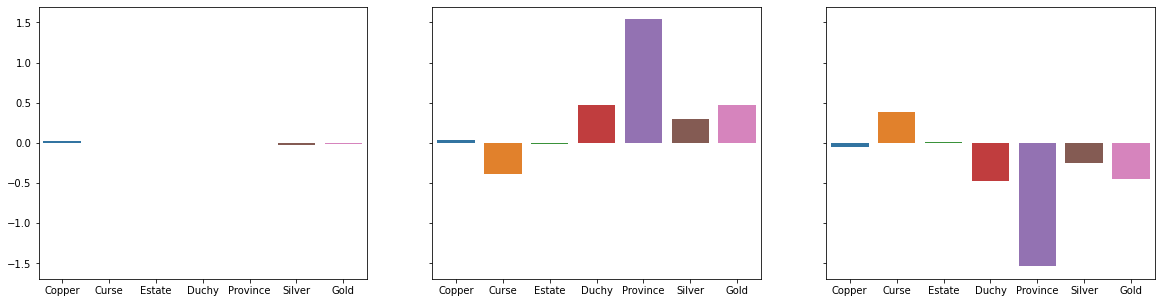

In [104]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

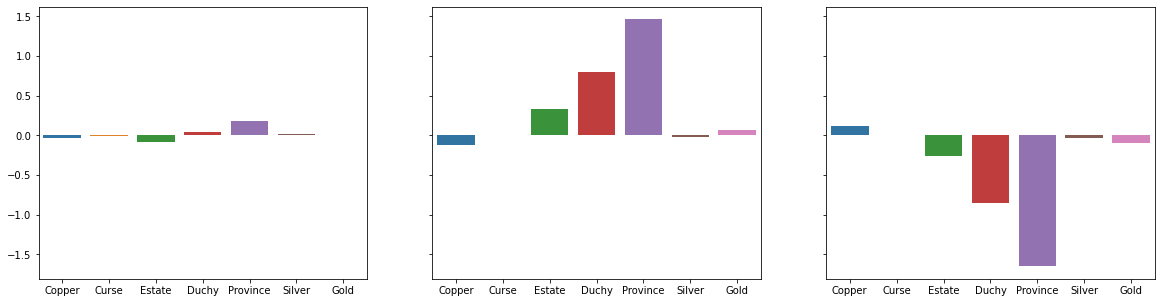

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])